# Two Moons: Tackling Bimodal Posteriors

## Table of Contents
 * [Inference Network and Amortizer](#inference_network_and)
 * [Trainer](#trainer)
 * [Validation](#validation)
	 * [Global Calibration](#global_calibration)
	 * [Two Moons Posterior](#two_moons_posterior)
 * [Further Experimentation](#further_experimentation)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm

import keras

## REMOVE ON PRODUCTION
import sys
sys.path.append('../')

import bayesflow as bf

## Simulator<a class="anchor" id="simulator"></a>

This example will demonstrate amortized estimation of a somewhat strange Bayesian model, whose posterior evaluated at the origin $x = (0, 0)$ of the "data" will resemble two crescent moons. The forward process is a noisy non-linear transformation on a 2D plane:

$$
\begin{align}
x_1 &= -|\theta_1 + \theta_2|/\sqrt{2} + r \cos(\alpha) + 0.25\\
x_2 &= (-\theta_1 + \theta_2)/\sqrt{2} + r\sin{\alpha}
\end{align}
$$

with $x = (x_1, x_2)$ playing the role of "observables", $\alpha \sim \text{Uniform}(-\pi/2, \pi/2)$, $r \sim \text{Normal}(0.1, 0.01)$, and a prior over the 2D parameter vector $\theta = (\theta_1, \theta_2)$:

$$
\begin{align}
\theta_1, \theta_2 \sim \text{Uniform}(-1, 1)
\end{align}
$$

This method is typically used for benchmarking simulation-based inference (SBI) methods (see https://arxiv.org/pdf/2101.04653) and any method for amortized Bayesian inference should be capable of recovering the two moons posterior *without* using a gazillion of simulations. Note, that this is a considerably harder task than modeling the common unconditional two moons data set used often in the context of normalizing flows.

In [2]:
# Set some hyperparameters
num_train_simulations = 10000
num_val_simulations = 300

# Create simulator object
simulator = bf.benchmarks.TwoMoons()

# Create training and validatin data
train_data = simulator.sample(batch_shape=num_train_simulations)
val_data = simulator.sample(batch_shape=num_val_simulations)

## Dataset and data adapter

In [3]:
# Create data adapter and specify which variables will be inferred based on which conditions
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["parameters"],
    inference_conditions=["observables"],
)

# Create data set wrappers to take care of batching during training
batch_size = 128
train_dataset = bf.datasets.OfflineDataset(train_data, batch_size=batch_size, data_adapter=data_adapter)
val_dataset = bf.datasets.OfflineDataset(val_data, batch_size=batch_size, data_adapter=data_adapter)

print(f"Number of training batches: {train_dataset.num_batches}")
print(f"Number of validation batches: {val_dataset.num_batches}")

Number of training batches: 79
Number of validation batches: 3


## Traing a neural network to approximate all posteriors <a class="anchor" id="train"></a>

### Optimizer and learning rate

In [20]:
epochs = 300

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=epochs * train_dataset.num_batches,
    alpha=1e-7,
    warmup_target=1e-3,
    warmup_steps=int(0.1 * epochs * train_dataset.num_batches),
)

optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=1e-3
)

### Flow matching as a posterior approximator

In [22]:
# Use flow matching as the most flexible sample currently available
inference_network = bf.networks.FlowMatching(
    subnet_kwargs=dict(
        depth=6,
        width=256,
    ),
)

# Wrap flow matching into an "approximator" with some additional utilities
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)
approximator.compile(optimizer=optimizer)

### Training

In [23]:
history = approximator.fit(
    epochs=epochs,
    dataset=train_dataset,
    workers=None,
    use_multiprocessing=False,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0576 - loss/inference_loss: 1.0576
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7235 - loss/inference_loss: 0.7235
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7187 - loss/inference_loss: 0.7187
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6837 - loss/inference_loss: 0.6837
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6869 - loss/inference_loss: 0.6869
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6809 - loss/inference_loss: 0.6809
Epoch 7/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6647 - loss/inference_loss: 0.6647
Epoch 8/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6943 - loss/inference_loss: 0.6943
Epoch 9/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6511 - loss/inference_loss: 0.6511
Epoch 10/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6719 - loss/inference_loss: 0.6719
Epoch 11/300
79/79 ━━━━━━━━━━━━━━━━━━━━

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5938 - loss/inference_loss: 0.5938
Epoch 126/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5925 - loss/inference_loss: 0.5925
Epoch 127/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5819 - loss/inference_loss: 0.5819
Epoch 128/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6011 - loss/inference_loss: 0.6011
Epoch 129/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5838 - loss/inference_loss: 0.5838
Epoch 130/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5758 - loss/inference_loss: 0.5758
Epoch 131/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5886 - loss/inference_loss: 0.5886
Epoch 132/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5738 - loss/inference_loss: 0.5738
Epoch 133/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5973 - loss/inference_loss: 0.5973
Epoch 134/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5872 - loss/inference_loss: 0.5872
Epoch 135/300
79/79 ━━━━━━━━━━━━━━

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5495 - loss/inference_loss: 0.5495
Epoch 250/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5582 - loss/inference_loss: 0.5582
Epoch 251/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5692 - loss/inference_loss: 0.5692
Epoch 252/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5473 - loss/inference_loss: 0.5473
Epoch 253/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5550 - loss/inference_loss: 0.5550
Epoch 254/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5640 - loss/inference_loss: 0.5640
Epoch 255/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5636 - loss/inference_loss: 0.5636
Epoch 256/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5571 - loss/inference_loss: 0.5571
Epoch 257/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5639 - loss/inference_loss: 0.5639
Epoch 258/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5401 - loss/inference_loss: 0.5401
Epoch 259/300
79/79 ━━━━━━━━━━━━━━

## Validation <a class="anchor" id="validation"></a>
We can use simulation-based calibration(SBC) for free (due to amortization) checking of computational faithfulness.

1. Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018). Validating Bayesian inference algorithms with simulation-based calibration. arXiv preprint arXiv:1804.06788.
2. Säilynoja, T., Bürkner, P. C., & Vehtari, A. (2022). Graphical test for discrete uniformity and its applications in goodness-of-fit evaluation and multiple sample comparison. Statistics and Computing, 32(2), 32.

In [ ]:
# TODO

### Two Moons Posterior <a class="anchor" id="two_moons_posterior"></a>

The two moons posterior at point $x = (0, 0)$ should resemble two crescent shapes. Below, we plot the corresponding posterior samples and posterior density. These results suggest that our spline flow setup can approximate the expected analytical posterior fairly well.

(-0.5, 0.5)

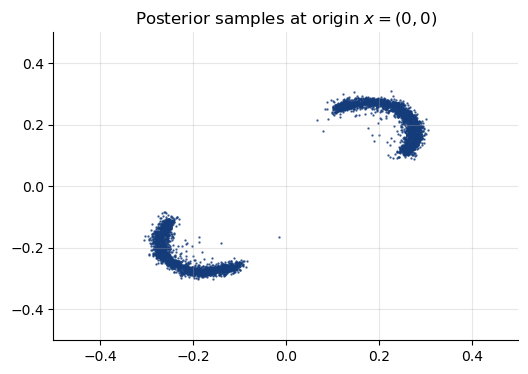

In [24]:
# Set the number of posterior draws you want to get
num_samples = 5000

# Prepare figure
f, axes = plt.subplots(1, figsize=(6, 4))

# Obtain samples from amortized posterior
obs_data = np.zeros((1, 2)).astype(np.float32)
samples_at_origin = approximator.sample(conditions={"observables": obs_data}, num_samples=num_samples)["parameters"]

# Plot samples
axes.scatter(samples_at_origin[0, :, 0], samples_at_origin[0, :, 1], color="#153c7a", alpha=0.75, s=0.5)
sns.despine(ax=axes)
axes.set_title(r"Posterior samples at origin $x=(0, 0)$")
axes.grid(alpha=0.3)
axes.set_xlim([-0.5, 0.5])
axes.set_ylim([-0.5, 0.5])

## Further Experimentation <a class="anchor" id="further_experimentation"></a>

# TODO